In [93]:
%reset -f

In [94]:
# importing the requests library 
import requests 
import pandas as pd
import numpy as np
import time
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

from sklearn.model_selection import train_test_split, GridSearchCV

from IPython import display

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Conv2D
from keras.layers import Bidirectional, AveragePooling1D, Flatten, TimeDistributed, AveragePooling2D
from keras.layers import Lambda

from sklearn import metrics
from scipy import stats

tf.test.gpu_device_name()

''

In [95]:
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

In [96]:
#Coingecko api
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [97]:
import time
import datetime

def edit_prices_dict(d): 
    df=pd.DataFrame(d)
    #Saving dates
    dates=df['prices'].map(lambda x: x[0])  
    #Filtering the values without dates
    df=df.applymap(lambda x: x[1])
    df['dates']=dates 
    df["dates"] = pd.to_datetime(df['dates'], unit='ms')
    df.index = df["dates"]
    df=df[['prices','total_volumes','market_caps']]
    return df

In [98]:
#dd/mm/yyyy
from_date = "01/01/2020"
to_date = "23/04/2022"
from_unix = time.mktime(datetime.datetime.strptime(from_date, "%d/%m/%Y").timetuple())
to_unix = time.mktime(datetime.datetime.strptime(to_date, "%d/%m/%Y").timetuple())

token = "bitcoin"; vs_currency = "usd"

response=cg.get_coin_market_chart_range_by_id(id = token, vs_currency = vs_currency, from_timestamp = from_unix, to_timestamp = to_unix)

In [99]:
df = edit_prices_dict(response)
print(df.shape)
df.tail()

(843, 3)


,prices,total_volumes,market_caps
dates,,,
2022-04-18,39739.119256,1.662778e+10,7.556272e+11
2022-04-19,40833.537965,3.061704e+10,7.764634e+11
2022-04-20,41498.122447,2.271777e+10,7.891418e+11
2022-04-21,41397.220477,2.493767e+10,7.874374e+11
2022-04-22,40528.541487,3.213122e+10,7.707872e+11


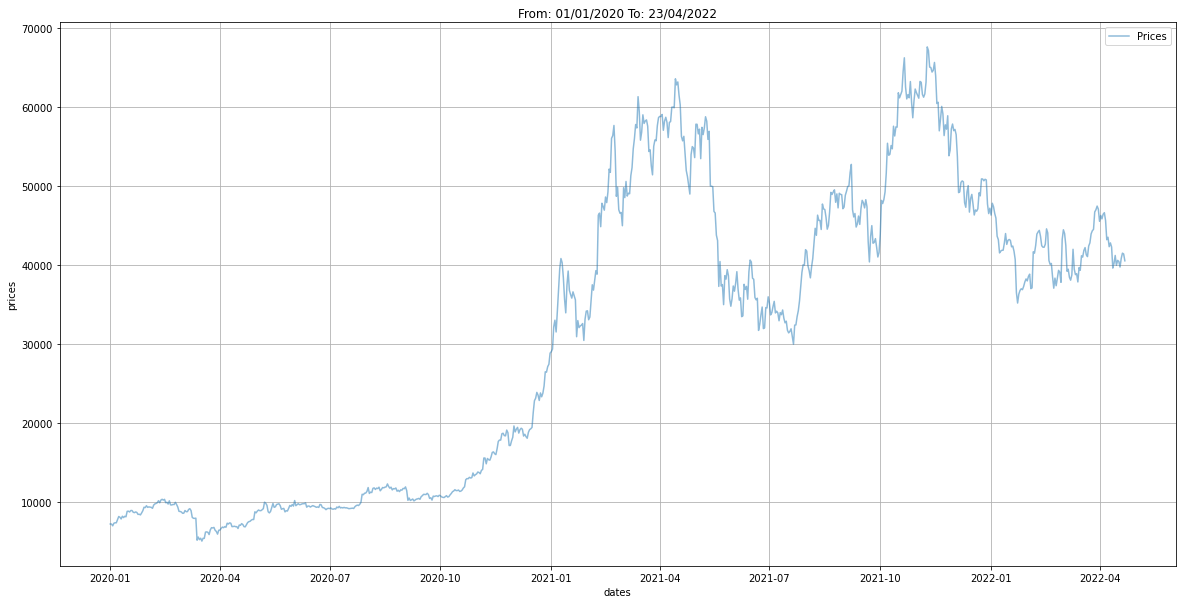

In [100]:
fig=plt.figure(figsize=(20, 10))
plt.plot(df['prices'], '-', label = 'Prices', alpha = 0.5)
plt.title('From: ' + from_date + ' To: ' + to_date) 
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)

In [101]:
#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
# MovingAverage
values_ma = [5,10,15,30]

for i in values_ma:
    df["ma_close_" + str(i)] = df["prices"].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = [5,10,15,30]

for i in values_ema:
    df["ema_" + str(i)] = df["prices"].ewm(span = i, adjust = False).mean()
    
# RSI https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = [7,10,14,21]
close = df['prices']

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    #roll_up1 = up.ewm(span=i).mean()
    #roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    #RS1 = roll_up1 / roll_down1
    #RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))
    
    #df["rsi_ewma_" + str(i)] = RSI1.values
    df["rsi_sma_" + str(i)]  = RSI2.values
    
# BollingerBand
values_bollinger = [5,10,20]
for i in values_bollinger:
    df['bollinger_upper_' + str(i)] = df['prices'].rolling(window=i).mean() + (df['prices'].rolling(window=i).std()  * 2)
    df['bollinger_lower_' + str(i)] = df['prices'].rolling(window=i).mean() - (df['prices'].rolling(window=i).std()  * 2)

In [102]:
df.tail(2)

,prices,total_volumes,market_caps,ma_close_5,ma_close_10,ma_close_15,ma_close_30,ema_5,ema_10,ema_15,ema_30,rsi_sma_7,rsi_sma_10,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20
dates,,,,,,,,,,,,,,,,,,,,,
2022-04-21,41397.220477,2.493767e+10,7.874374e+11,40783.675890,40547.924565,41305.345721,43404.299468,41026.828142,41192.460921,41575.186601,42112.954178,52.096527,45.042651,42.077856,34.501395,42229.892417,39337.459363,41907.236032,39188.613098,47367.255707,37671.262729
2022-04-22,40528.541487,3.213122e+10,7.707872e+11,40799.308326,40640.382198,41127.330135,43341.854331,40860.732590,41071.748296,41444.355962,42010.734004,56.769653,56.557169,37.475093,35.806525,42229.108078,39369.508575,41829.447087,39451.317308,46817.843741,37646.508773


In [103]:
# Esto hay que hacerlo pues es con la info de hoy predecir mañana
df["percen_diff"] = df["prices"].shift(-1)
df[["prices","percen_diff"]].tail(3)

,prices,percen_diff
dates,,
2022-04-20,41498.122447,41397.220477
2022-04-21,41397.220477,40528.541487
2022-04-22,40528.541487,NaN


In [104]:
df["percen_diff"] = 100*( (df["percen_diff"] - df["prices"])/df["prices"])   
df[["prices","percen_diff"]].tail(3)

,prices,percen_diff
dates,,
2022-04-20,41498.122447,-0.243148
2022-04-21,41397.220477,-2.098399
2022-04-22,40528.541487,NaN


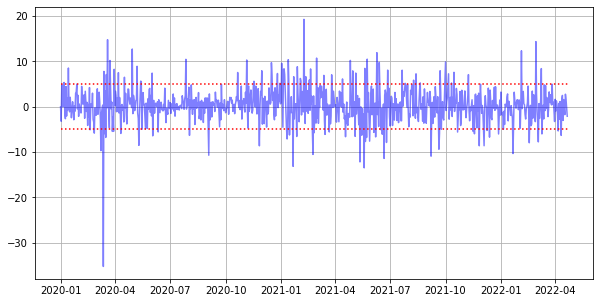

In [105]:
cota = 5
cota_max = 1 * cota
cota_min = -1 * cota

fig=plt.figure(figsize=(10, 5))
plt.plot(df['percen_diff'], 'b', label = 'Delta', alpha = 0.5)
plt.hlines(cota_max, df.index.min(), df.index.max(), color='r', ls=':')
plt.hlines(cota_min, df.index.min(), df.index.max(), color='r', ls=':')
plt.grid(True)

In [106]:
def get_target(x):
  # reducir margenes
  if x < cota_min: return "sell"
  elif x > cota_max: return "buy"
  else: return "hold"

df['target'] = df['percen_diff'].apply(lambda x: get_target(x))
df = df.join(pd.get_dummies(df.target))

In [107]:
df.tail()

,prices,total_volumes,market_caps,ma_close_5,ma_close_10,ma_close_15,ma_close_30,ema_5,ema_10,ema_15,ema_30,rsi_sma_7,rsi_sma_10,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,percen_diff,target,buy,hold,sell
dates,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-18,39739.119256,1.662778e+10,7.556272e+11,40388.144332,40913.737933,42302.930533,43431.570599,40353.311125,41121.230090,41726.924817,42302.920380,31.867737,29.464910,24.488499,30.136303,41535.224078,39241.064586,43249.603501,38577.872366,48903.756934,37766.976837,2.754008,hold,0,1,0
2022-04-19,40833.537965,3.061704e+10,7.764634e+11,40313.818181,40765.520757,41929.528866,43385.957201,40513.386738,41068.922431,41615.251460,42208.121514,61.351400,41.846408,29.367020,33.233830,41218.813595,39408.822767,42883.992608,38647.048907,48322.187422,37685.974022,1.627546,hold,0,1,0
2022-04-20,41498.122447,2.271777e+10,7.891418e+11,40621.551257,40635.693254,41587.894648,43393.119316,40841.631974,41146.958797,41600.610333,42162.315123,61.794908,42.999680,34.907025,33.953458,41895.334310,39347.768203,42314.518224,38956.868284,47722.285672,37729.351432,-0.243148,hold,0,1,0
2022-04-21,41397.220477,2.493767e+10,7.874374e+11,40783.675890,40547.924565,41305.345721,43404.299468,41026.828142,41192.460921,41575.186601,42112.954178,52.096527,45.042651,42.077856,34.501395,42229.892417,39337.459363,41907.236032,39188.613098,47367.255707,37671.262729,-2.098399,hold,0,1,0
2022-04-22,40528.541487,3.213122e+10,7.707872e+11,40799.308326,40640.382198,41127.330135,43341.854331,40860.732590,41071.748296,41444.355962,42010.734004,56.769653,56.557169,37.475093,35.806525,42229.108078,39369.508575,41829.447087,39451.317308,46817.843741,37646.508773,NaN,hold,0,1,0


In [108]:
df_rs = df.drop(['percen_diff', 'target'], axis=1)
df_rs = np.array(df_rs)

In [109]:
def split_sequence(sequence, n_steps_in):
    X, y = list(), list()
    range = np.arange(start = 0, stop = len(sequence), step = 1) # Ojo con el step que te fundio :)
    for i in range:
        # find the end of this pattern
        end_ix = i + n_steps_in
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix, :-3]
        seq_y = sequence[i:end_ix, -3:][-1]
        if len(seq_x) == n_steps_in:
          X.append(seq_x)
          y.append(seq_y)
    return np.array(X), np.array(y)

In [110]:
past_t = 60
forecast_t = 2
n_steps_in = past_t
# split into samples
X, y = split_sequence(df_rs, n_steps_in)
print("Shape X --> " + str(X.shape))
print("Shape y --> " + str(y.shape))

Shape X --> (784, 60, 21)
Shape y --> (784, 3)


In [111]:
test_size = 200
train_size = len(X) - test_size
X_train = X[0:train_size]
y_train = y[0:train_size]
X_test = X[train_size:len(X)]
y_test = y[train_size:len(X)]
print("Shape X_train --> " + str(X_train.shape))
print("Shape y_train --> " + str(y_train.shape))
print("Shape X_test  --> " + str(X_test.shape))
print("Shape y_test  --> " + str(y_test.shape))

Shape X_train --> (584, 60, 21)
Shape y_train --> (584, 3)
Shape X_test  --> (200, 60, 21)
Shape y_test  --> (200, 3)


In [112]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import activations

# https://keras.io/api/applications/

In [113]:
# Get square shape
image_shape = X_train.shape[1]

if X_train.shape[1]<X_train.shape[2]:
  image_shape = X_train.shape[2]

# Load Resnet model
base_model = tf.keras.applications.EfficientNetV2L(
    weights='imagenet',
    input_shape=(image_shape, image_shape, 3),
    include_top=False) 
base_model.trainable = False

# Create input as image
inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
if X_train.shape[1]<X_train.shape[2]:
  input_img = layers.Reshape((X_train.shape[2], X_train.shape[1]))(inputs) 
  input_img = layers.Dense(image_shape, activation='tanh')(input_img) # Create a square matrix 
  input_img = layers.Reshape((image_shape, image_shape, 1))(input_img) # Reshape into an image with 1 channels
  input_img = layers.Dense(3, activation='tanh', name='image_inp')(input_img) # Learn 3 channels
else:
  input_img = layers.Dense(image_shape, activation='tanh')(inputs) # Create a square matrix 
  input_img = layers.Reshape((image_shape, image_shape, 1))(input_img) # Reshape into an image with 1 channels
  input_img = layers.Dense(3, activation='tanh', name='image_inp')(input_img) # Learn 3 channels
# With tahn all outputs are between -1 and 1 (ResNet needs that)

# Create Model
x = base_model(input_img, training=False)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.2)(x) 

# Output layer
predictions = layers.Dense(y_train.shape[1], activation="softmax")(x) #Relu for getting positive values
model = tf.keras.Model(inputs, predictions)

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics='accuracy')
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 60, 21)]          0         
                                                                 
 dense_6 (Dense)             (None, 60, 60)            1320      
                                                                 
 reshape_3 (Reshape)         (None, 60, 60, 1)         0         
                                                                 
 image_inp (Dense)           (None, 60, 60, 3)         6         
                                                                 
 efficientnetv2-l (Functiona  (None, 2, 2, 1280)       117746848 
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [115]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=1, factor=0.5, min_lr=2.5e-5)
checkpoint = keras.callbacks.ModelCheckpoint('backup/modelo_prueba{epoch:08d}.h5', save_freq = 30) 

In [116]:
history = model.fit(X_train, y_train, epochs = 10, batch_size = 1, 
                    callbacks=[learning_rate_reduction, early_stopping],
                    validation_data= (X_test, y_test))

Epoch 1/10
584/584 [==============================] - 183s 286ms/step - loss: nan - accuracy: 0.1147 - val_loss: nan - val_accuracy: 0.0350 - lr: 0.0100
Epoch 2/10
584/584 [==============================] - 163s 279ms/step - loss: nan - accuracy: 0.0925 - val_loss: nan - val_accuracy: 0.0350 - lr: 0.0100
Epoch 3/10
584/584 [==============================] - 166s 284ms/step - loss: nan - accuracy: 0.0925 - val_loss: nan - val_accuracy: 0.0350 - lr: 0.0100
Epoch 4/10
584/584 [==============================] - 163s 280ms/step - loss: nan - accuracy: 0.0925 - val_loss: nan - val_accuracy: 0.0350 - lr: 0.0100
Epoch 5/10
584/584 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0925
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
584/584 [==============================] - 165s 282ms/step - loss: nan - accuracy: 0.0925 - val_loss: nan - val_accuracy: 0.0350 - lr: 0.0100
Epoch 6/10
584/584 [==============================] - 166s 284ms/step - loss: 

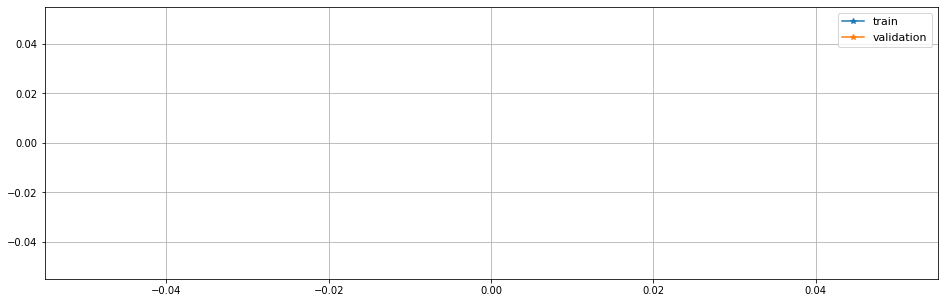

In [117]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

In [ ]:
model_path = folder + 'modelo_best.h5'
checkpoint = ModelCheckpoint(model_path, monitor="val_loss",
                             save_freq = 'epoch', save_best_only=True, mode='min')

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# Very low learning rate 
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics='accuracy') 

history = model.fit(X_train, y_train, epochs = 100, batch_size = 16,
                    validation_data= (X_test, y_test),
                    callbacks=[early_stopping, checkpoint])

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)